MNIST ZERO AND ONE 94.7 PERCENT

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import snntorch as snn
from brevitas.nn import QuantLinear
from brevitas.core.quant import QuantType
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def split_image_into_three(tensor):

    tensor = torch.nn.functional.pad(tensor, (0, 2), "constant", 0)  # Padding 2 pixels
    tensor = tensor.view(-1)  # Flatten the tensor
    section_size = tensor.size(0) // 3

    sections = []
    start_index = 0
    for _ in range(3):
        sections.append(tensor[start_index:start_index + section_size])
        start_index += section_size

    return torch.stack(sections)

transform = transforms.Compose([
    transforms.ToTensor(),
    split_image_into_three  # Outputs a tensor of shape [3, 262]
])

# Loading and filtering datasets
def filter_dataset(dataset):
    indices = [i for i, (img, label) in enumerate(dataset) if label in [0, 1]]
    return Subset(dataset, indices)

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = filter_dataset(train_dataset)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = filter_dataset(test_dataset)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

class MNISTNetSNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, timesteps, beta):
        super().__init__()
        self.timesteps = timesteps
        self.beta = beta
        
        self.fc1_sections = nn.ModuleList([
            QuantLinear(input_size, 1, bias=True, bit_width=8,
                        weight_quant_type=QuantType.INT, weight_bit_width=8) for _ in range(3)
        ])
        self.rlif1 = snn.Leaky(beta=self.beta)
        
        self.fc_mid = QuantLinear(3, 3, bias=True, bit_width=8,
                                  weight_quant_type=QuantType.INT, weight_bit_width=8)
        self.rlif_mid = snn.Leaky(beta=self.beta)
        
        self.fc2 = QuantLinear(3, output_size, bias=True, bit_width=8,
                               weight_quant_type=QuantType.INT, weight_bit_width=8)
        self.rlif2 = snn.Leaky(beta=self.beta)

    def forward(self, x):
        mem1 = [None] * 3
        mem_mid = None
        mem2 = None
        spk_recording = []

        for step in range(self.timesteps):
            spk1 = []
            for i, fc1 in enumerate(self.fc1_sections):
                cur1 = fc1(x[:, i, step].view(-1, 1))
                spk, mem = self.rlif1(cur1, mem1[i] if mem1[i] is not None else torch.zeros_like(cur1))
                spk1.append(spk)
                mem1[i] = mem

            spk1 = torch.cat(spk1, dim=1)

            cur_mid = self.fc_mid(spk1)
            spk_mid, mem_mid = self.rlif_mid(cur_mid, mem_mid if mem_mid is not None else torch.zeros_like(cur_mid))

            cur2 = self.fc2(spk_mid)
            spk2, mem2 = self.rlif2(cur2, mem2 if mem2 is not None else torch.zeros_like(cur2))

            spk_recording.append(spk2)

        return torch.stack(spk_recording, dim=0)

model = MNISTNetSNN(input_size=1, hidden_size=3, output_size=2, timesteps=262, beta=0.9).to(device)

# Cross Entropy Loss after summing spikes
def spike_count_loss(outputs, targets):
    outputs_summed = outputs.sum(dim=0)
    return F.cross_entropy(outputs_summed, targets)

# Optimizer and Loss Function
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = spike_count_loss

num_epochs = 20
model.train()
for epoch in range(num_epochs):
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()

        print(f'Epoch {epoch}, Loss: {loss.item()}')

model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        output = model(data)
        predicted = output.sum(dim=0).argmax(dim=1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

print(f"Accuracy: {100 * correct / total:.2f}%")


/Users/georgepsaltakis/opt/anaconda3/lib/python3.9/site-packages/torch/_tensor.py:1362: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/c10/core/TensorImpl.h:1903.)
  return super().rename(names)


Epoch 0, Loss: 63.875
Epoch 0, Loss: 49.1015625
Epoch 0, Loss: 69.5625
Epoch 0, Loss: 57.3671875
Epoch 0, Loss: 58.9921875
Epoch 0, Loss: 56.21875
Epoch 0, Loss: 59.1875
Epoch 0, Loss: 59.5
Epoch 0, Loss: 65.8359375
Epoch 0, Loss: 67.0078125
Epoch 0, Loss: 53.8046875
Epoch 0, Loss: 58.796875
Epoch 0, Loss: 56.796875
Epoch 0, Loss: 64.9140625
Epoch 0, Loss: 65.4765625
Epoch 0, Loss: 50.984375
Epoch 0, Loss: 51.6875
Epoch 0, Loss: 53.8671875
Epoch 0, Loss: 49.84375
Epoch 0, Loss: 62.0546875
Epoch 0, Loss: 55.4296875
Epoch 0, Loss: 52.1796875
Epoch 0, Loss: 56.8671875
Epoch 0, Loss: 54.28125
Epoch 0, Loss: 58.1796875
Epoch 0, Loss: 52.6015625
Epoch 0, Loss: 49.28125
Epoch 0, Loss: 53.8984375
Epoch 0, Loss: 52.8359375
Epoch 0, Loss: 53.0859375
Epoch 0, Loss: 55.421875
Epoch 0, Loss: 58.8515625
Epoch 0, Loss: 44.0625
Epoch 0, Loss: 47.75
Epoch 0, Loss: 49.0234375
Epoch 0, Loss: 52.8046875
Epoch 0, Loss: 52.8359375
Epoch 0, Loss: 52.9453125
Epoch 0, Loss: 44.53125
Epoch 0, Loss: 50.9375
Epoc

MUTLICLASS MNIST 0 1 2

In [3]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import snntorch as snn
from brevitas.nn import QuantLinear
from brevitas.core.quant import QuantType
import torch.nn.functional as F

=device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def split_image_into_three(tensor):

    tensor = torch.nn.functional.pad(tensor, (0, 2), "constant", 0)  # Padding 2 pixels
    tensor = tensor.view(-1)  # Flatten the tensor
    section_size = tensor.size(0) // 3

    sections = []
    start_index = 0
    for _ in range(3):
        sections.append(tensor[start_index:start_index + section_size])
        start_index += section_size

    return torch.stack(sections)

transform = transforms.Compose([
    transforms.ToTensor(),
    split_image_into_three  
])


def filter_dataset(dataset):
    indices = [i for i, (img, label) in enumerate(dataset) if label in [0, 1, 2]]
    return Subset(dataset, indices)

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_dataset = filter_dataset(train_dataset)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = filter_dataset(test_dataset)

train_loader = DataLoader(dataset=train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=128, shuffle=False)

class MNISTNetSNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, timesteps, beta):
        super().__init__()
        self.timesteps = timesteps
        self.beta = beta
        
        self.fc1_sections = nn.ModuleList([
            QuantLinear(input_size, 1, bias=True, bit_width=8,
                        weight_quant_type=QuantType.INT, weight_bit_width=8) for _ in range(3)
        ])
        self.rlif1 = snn.Leaky(beta=self.beta)
        
        self.fc_mid = QuantLinear(3, 3, bias=True, bit_width=8,
                                  weight_quant_type=QuantType.INT, weight_bit_width=8)
        self.rlif_mid = snn.Leaky(beta=self.beta)
        
        self.fc2 = QuantLinear(3, output_size, bias=True, bit_width=8,
                               weight_quant_type=QuantType.INT, weight_bit_width=8)
        self.rlif2 = snn.Leaky(beta=self.beta)

    def forward(self, x):
        mem1 = [None] * 3
        mem_mid = None
        mem2 = None
        spk_recording = []

        for step in range(self.timesteps):
            spk1 = []
            for i, fc1 in enumerate(self.fc1_sections):
                cur1 = fc1(x[:, i, step].view(-1, 1))
                spk, mem = self.rlif1(cur1, mem1[i] if mem1[i] is not None else torch.zeros_like(cur1))
                spk1.append(spk)
                mem1[i] = mem

            spk1 = torch.cat(spk1, dim=1)  # Concatenate spikes from all sections

            cur_mid = self.fc_mid(spk1)
            spk_mid, mem_mid = self.rlif_mid(cur_mid, mem_mid if mem_mid is not None else torch.zeros_like(cur_mid))

            cur2 = self.fc2(spk_mid)
            spk2, mem2 = self.rlif2(cur2, mem2 if mem2 is not None else torch.zeros_like(cur2))

            spk_recording.append(spk2)

        return torch.stack(spk_recording, dim=0)

model = MNISTNetSNN(input_size=1, hidden_size=3, output_size=3, timesteps=262, beta=0.9).to(device)


def spike_count_loss(outputs, targets):
    outputs_summed = outputs.sum(dim=0)  # Sum across time dimension
    return F.cross_entropy(outputs_summed, targets)

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_function = spike_count_loss

num_epochs = 25
model.train()
for epoch in range(num_epochs):
    for data, targets in train_loader:
        data = data.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()
        output = model(data)
        loss = loss_function(output, targets)
        loss.backward()
        optimizer.step()

        print(f'Epoch {epoch}, Loss: {loss.item()}')

model.eval()
total = 0
correct = 0
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)
        output = model(data)
        predicted = output.sum(dim=0).argmax(dim=1)
        correct += (predicted == targets).sum().item()
        total += targets.size(0)

print(f"Accuracy: {100 * correct / total:.2f}%")


Epoch 0, Loss: 27.703125
Epoch 0, Loss: 22.640625
Epoch 0, Loss: 22.8203125
Epoch 0, Loss: 24.5
Epoch 0, Loss: 24.3359375
Epoch 0, Loss: 20.0078125
Epoch 0, Loss: 20.4609375
Epoch 0, Loss: 22.21875
Epoch 0, Loss: 21.3359375
Epoch 0, Loss: 21.328125
Epoch 0, Loss: 21.09375
Epoch 0, Loss: 18.28125
Epoch 0, Loss: 20.6015625
Epoch 0, Loss: 18.25
Epoch 0, Loss: 20.1015625
Epoch 0, Loss: 18.0546875
Epoch 0, Loss: 20.109375
Epoch 0, Loss: 18.8984375
Epoch 0, Loss: 16.3046875
Epoch 0, Loss: 18.1796875
Epoch 0, Loss: 19.3046875
Epoch 0, Loss: 17.671875
Epoch 0, Loss: 18.5703125
Epoch 0, Loss: 15.8203125
Epoch 0, Loss: 17.4921875
Epoch 0, Loss: 17.2578125
Epoch 0, Loss: 15.6171875
Epoch 0, Loss: 14.90625
Epoch 0, Loss: 14.0078125
Epoch 0, Loss: 13.796875
Epoch 0, Loss: 13.6328125
Epoch 0, Loss: 14.21875
Epoch 0, Loss: 15.265625
Epoch 0, Loss: 13.9609375
Epoch 0, Loss: 13.4296875
Epoch 0, Loss: 13.5078125
Epoch 0, Loss: 11.9921875
Epoch 0, Loss: 13.203125
Epoch 0, Loss: 13.515625
Epoch 0, Loss: 1

In [4]:
torch.save(model.state_dict(), 'mnist_snn_model_weights.pth')

print("Model weights saved successfully.")


Model weights saved successfully.


In [7]:
model.load_state_dict(torch.load('mnist_snn_model_weights.pth'))
model.eval()  

MNISTNetSNN(
  (fc1_sections): ModuleList(
    (0-2): 3 x QuantLinear(
      in_features=1, out_features=1, bias=True
      (input_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (output_quant): ActQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
      )
      (weight_quant): WeightQuantProxyFromInjector(
        (_zero_hw_sentinel): StatelessBuffer()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClampSte()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): StatsFromParameterScaling(
            (parameter_list_stats): _ParameterListStats(
              (first_tracked_param): _ViewParameterWrapper(
                (view_shape_impl): OverTensorView()
              )
              (stats): _Stats(
                (stats_impl):

In [16]:
import torch

model.load_state_dict(torch.load('best_mnist_snn_model_weights-Copy1.pth'))

model.eval()

correct = 0
total = 0
with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        output = model(data)

        predicted = output.sum(dim=0).argmax(dim=1)

        correct += (predicted == targets).sum().item()
        total += targets.size(0)

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')



Test Accuracy: 88.69%


              precision    recall  f1-score   support

           0       0.86      0.94      0.90       980
           1       0.90      0.91      0.90      1135
           2       0.91      0.81      0.86      1032

    accuracy                           0.89      3147
   macro avg       0.89      0.89      0.89      3147
weighted avg       0.89      0.89      0.89      3147

Confusion Matrix:
[[ 919   18   43]
 [  59 1034   42]
 [  95   99  838]]


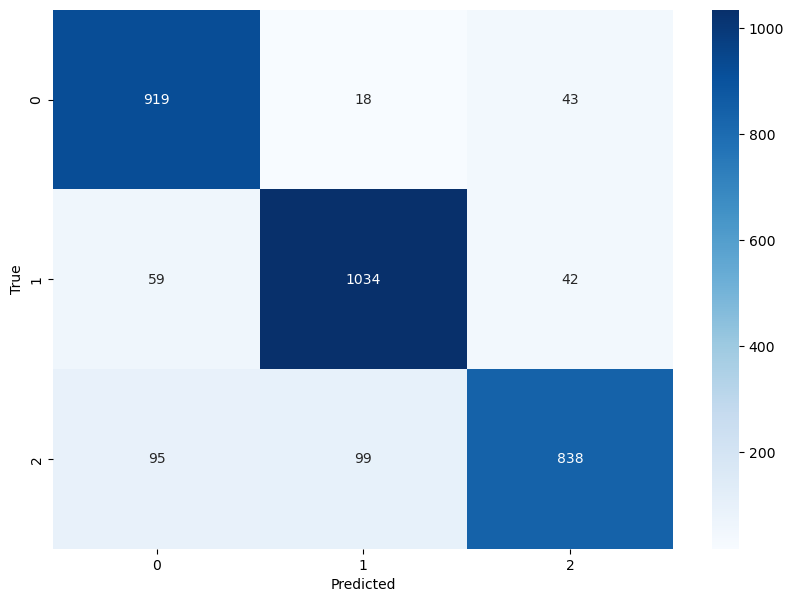

In [17]:
import torch
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

model.load_state_dict(torch.load('best_mnist_snn_model_weights-Copy1.pth'))

model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for data, targets in test_loader:
        data = data.to(device)
        targets = targets.to(device)

        output = model(data)

        predicted = output.sum(dim=0).argmax(dim=1).cpu().numpy()
        targets = targets.cpu().numpy()

        all_preds.extend(predicted)
        all_targets.extend(targets)

all_preds = np.array(all_preds)
all_targets = np.array(all_targets)

print(classification_report(all_targets, all_preds))

cm = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(cm)

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()
